Here I downloaded Alexander Ivanov's code for Agglomerative Clustering to have an idea of how structure my Agglomerative clustering script

Loading Data from: C:/Users/oluwa/Downloads/TiNiSn_500C-20200714T190740Z-001/TiNiSn_500C/
Data Loaded Succesfully


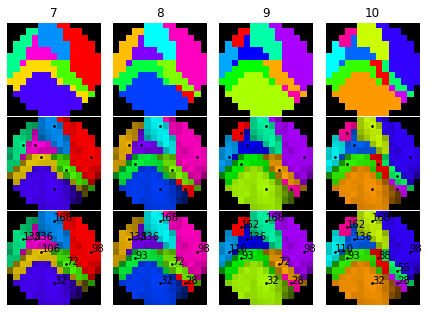

In [1]:
"""
Cosine based Clustering
Produces a set of clustering images along with cluster centers and cluster membership.
Darker locations are further from the cluster center in terms of cosine similarity.
"""

from data_grid_TiNiSn import DataGrid_TiNiSn_500C, DataGrid_TiNiSn_600C

#from pyclustering.cluster.kmeans import kmeans
#from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math



#folder with data files

dataGrid = DataGrid_TiNiSn_500C()


'''
for k in dataGrid.data.keys():
    x = dataGrid.data[k][:,1]
    plt.plot(x)
    peaks,_ = find_peaks(x)
    plt.plot(peaks,x[peaks], "x")
    plt.show()
x = dataGrid.data[73][:,1]
plt.plot(x)
peaks,_ = find_peaks(x)
plt.plot(peaks,x[peaks], "x")
x = dataGrid.data[29][:,1]
plt.plot(x)
peaks,_ = find_peaks(x)
plt.plot(peaks,x[peaks], "x")
plt.show()
'''

def similarity_vector(A,B):
    pA, _ = find_peaks(A)
    pB, _ = find_peaks(B)
    p = np.append(pA,pB,axis=0)
    cosine =  np.dot(A,B)/np.linalg.norm(A)/np.linalg.norm(B)
    peaks = np.dot(A[p],B[p])/np.linalg.norm(A[p])/np.linalg.norm(B[p])
    return cosine

#cosine similarity function using two grid positions
def similarity(d1,d2):
    a = dataGrid.data[d1][:,1]
    b = dataGrid.data[d2][:,1]
    return similarity_vector(a,b)





#create grid
grid = np.zeros(shape=(15,15))

#calculate similarity values for grid
for val in range(1,178):
    x,y = dataGrid.coord(val)
    #keys = ['up','left']
    keys = ['up', 'left', 'right', 'down']
    neigh = [dataGrid.neighbors(val)[k] for k in dataGrid.neighbors(val).keys() if k in keys]
    sim_values = [similarity(val,n) for n in neigh]
    if len(sim_values) == 0:
        grid[y-1][15-x] = 1
        continue
    grid[y-1][15-x] = np.min(sim_values)


def getPointsX(x,list):
    if len(list) == 0:
        return []
    dir = list.pop(0)
    if dir in ['u','d','s']:
        return [x] + getPointsX(x,list)
    elif dir == 'l':
        return [x-1] + getPointsX(x-1,list)
    else:
        return [x+1] + getPointsX(x+1,list)

def getPointsY(y,list):
    if len(list) == 0:
        return []
    dir = list.pop(0)
    if dir in ['l','r','s']:
        return [y] + getPointsY(y,list)
    elif dir == 'd':
        return [y-1] + getPointsY(y-1,list)
    else:
        return [y+1] + getPointsY(y+1,list)

l1 = list('suuluuulululllldldll')
l1x = getPointsX(9.5,l1.copy())
l1y = getPointsY(-.5,l1.copy())

l2 = list('sululull')
l2x = getPointsX(12.5,l2.copy())
l2y = getPointsY(1.5,l2.copy())

l3 = list('sululululllldldldl')
l3x = getPointsX(9.5,l3.copy())
l3y = getPointsY(4.5,l3.copy())

l4 = list('sululululuuuuuluulu')
l4x = getPointsX(13.5,l4.copy())
l4y = getPointsY(2.5,l4.copy())

l5 = list('sldl')
l5x = getPointsX(9.5,l5.copy())
l5y = getPointsY(8.5,l5.copy())

l6 = list('sullllld')
l6x = getPointsX(8.5,l6.copy())
l6y = getPointsY(8.5,l6.copy())

l7 = list('sulluuuu')
l7x = getPointsX(6.5,l7.copy())
l7y = getPointsY(9.5,l7.copy())

l8 = list('sdddldlll')
l8x = getPointsX(3.5,l8.copy())
l8y = getPointsY(13.5,l8.copy())

l9 = list('sddldl')
l9x = getPointsX(1.3,l9.copy())
l9y = getPointsY(9.5,l9.copy())

#uncomment to plot clustering lines from matplotlib code
'''
grid[grid==0] = np.nan
plt.figure(1)
plt.imshow(grid)
#x,y = dataGrid.coord(15)
#plt.plot([x-1],[y-1],marker='o', markersize=3, color="red")
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.plot(l1x,l1y,color="red")
plt.plot(l2x,l2y,color="red")
plt.plot(l3x,l3y,color="red")
plt.plot(l4x,l4y,color="red")
plt.plot(l5x,l5y,color="red")
plt.plot(l6x,l6y,color="red")
plt.plot(l7x,l7y,color="red")
plt.plot(l8x,l8y,color="red")
plt.plot(l9x,l9y,color="red")
'''




from sklearn.cluster import AgglomerativeClustering

points = [[6,1]]
for val in range(2,178):
    x,y = dataGrid.coord(val)
    points = np.append(points,[[x,y]],axis=0)

size = len(points)
D = np.ones(shape=(size,size))
for x in range(size):
    for y in range(size):
        D[x,y] = 1 - similarity(x+1,y+1)


#calculate i clusters and create grid visuals and center points

def get_cluster_grids(i):
    agg = AgglomerativeClustering(n_clusters=i, compute_full_tree = True, affinity='precomputed',linkage='complete')
    agg.fit(D)

    hues = [float(float(x)/float(i)) for x in range(1,i+1)]

    grouped_data = [[] for x in range(i)]

    for loc,val in enumerate(agg.labels_):
        grouped_data[val].append(dataGrid.data_at_loc(loc+1)[:,1])
    averages = [np.mean(x,axis=0) for x in grouped_data]

    cluster_grid = np.zeros(shape = (15,15,3))
    cluster_grid_scale = np.zeros(shape = (15,15,3))
    for val in range(1,178):
        x,y = dataGrid.coord(val)
        cluster = agg.labels_[val-1]
        similarity = similarity_vector(dataGrid.data_at_loc(val)[:,1],averages[cluster])

        similarity = math.pow(similarity,10)
        cluster_grid_scale[y-1][15-x] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,similarity])
        cluster_grid[y-1][15-x] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,1])

    points_x = [-1 for x in range(i)]
    points_y = [-1 for x in range(i)]
    points_loc = [-1 for x in range(i)]

    for loc in range(1,178):
        cluster = agg.labels_[loc-1]
        cur_x = points_x[cluster]
        cur_y = points_y[cluster]
        if cur_x == -1:
            x,y = dataGrid.coord(loc)
            points_x[cluster] = x
            points_y[cluster] = y
            points_loc[cluster] = loc
            continue
        sim_cur = similarity_vector(dataGrid.data_at(cur_x,cur_y)[:,1],averages[cluster])
        sim_new = similarity_vector(dataGrid.data_at_loc(loc)[:,1],averages[cluster])
        if sim_cur < sim_new:
            x,y = dataGrid.coord(loc)
            points_x[cluster] = x
            points_y[cluster] = y
            points_loc[cluster] = loc


    return cluster_grid, cluster_grid_scale, points_x, points_y, points_loc


min = 7
max = 10
cluster_range = range(min,max+1)

fig = plt.figure()
ax = fig.subplots(nrows=3, ncols=len(cluster_range))

for n,i in enumerate(cluster_range):
    cg, cgs, px, py, pl = get_cluster_grids(i)
    px = [15-x for x in px]
    py = [y-1 for y in py]
    ax[0,n].imshow(cg)
    ax[0,n].invert_yaxis()
    ax[0,n].axis("off")
    ax[0,n].title.set_text(i)

    ax[1,n].imshow(cgs)
    ax[1,n].scatter(px,py,s=3,c='black')
    ax[1,n].invert_yaxis()
    ax[1,n].axis("off")

    ax[2,n].imshow(cgs)
    ax[2,n].scatter(px,py,s=3,c='black')
    ax[2,n].invert_yaxis()
    ax[2,n].axis("off")
    for i,txt in enumerate(pl):
        ax[2,n].annotate(txt,(px[i],py[i]))

fig.tight_layout()
k=.01
plt.subplots_adjust(left=k,right=(1-k),bottom=k,top=(1-k),wspace=k,hspace=k)
#plt.savefig("/home/sasha/Desktop/cluster_images/clustering-" + str(min) + "-" + str(max) + ".png")
plt.show()
